# Get Data

In [5]:
import threading
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.data = {'SPX': [], 'VIX': []}  # Dictionary to store data by symbol

    def historicalData(self, reqId, bar):
        if reqId == 1:  # Data for SPX
            print(f'SPX - Time: {bar.date}, Close: {bar.close}')
            self.data['SPX'].append([bar.date, bar.close])
        elif reqId == 2:  # Data for VIX
            print(f'VIX - Time: {bar.date}, Close: {bar.close}')
            self.data['VIX'].append([bar.date, bar.close])

def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7497, 123)

# Start the socket in a thread
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

time.sleep(1)  # Sleep interval to allow time for connection to server

# Define the contract for S&P 500
sp500_contract = Contract()
sp500_contract.symbol = 'SPX'
sp500_contract.secType = 'IND'
sp500_contract.exchange = 'CBOE'
sp500_contract.currency = 'USD' 

# Define the contract for VIX
vix_contract = Contract()
vix_contract.symbol = 'VIX'
vix_contract.secType = 'IND'
vix_contract.exchange = 'CBOE'
vix_contract.currency = 'USD'

# Request historical data
app.reqHistoricalData(1, sp500_contract, '', '25 Y', '1 day', 'TRADES', 0, 2, False, [])
app.reqHistoricalData(2, vix_contract, '', '25 Y', '1 day', 'TRADES', 0, 2, False, [])

time.sleep(10)  # Allow time for data to be returned

# Disconnect from the server
app.disconnect()

# Convert data to pandas DataFrame
sp = pd.DataFrame(app.data['SPX'], columns=['DateTime', 'Close'])
sp['DateTime'] = pd.to_datetime(sp['DateTime'])
sp.rename(columns={'Close':'SPX'}, inplace=True)

vix = pd.DataFrame(app.data['VIX'], columns=['DateTime', 'Close'])
vix['DateTime'] = pd.to_datetime(vix['DateTime'])
vix.rename(columns={'Close':'VIX'}, inplace=True)

df = pd.merge(sp, vix, on='DateTime', how='left')

df = df.dropna().reset_index()


ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
ERROR 1 504 Not connected
ERROR 2 504 Not connected


# Bias-UDM Signal

In [2]:

def calculate_bias(data, column, short_window):
    """
    Calculate BIAS (Deviation Rate).

    Parameters:
    - data: DataFrame, contains the input data
    - column: str, name of the column (e.g., 'SPX') to calculate BIAS for
    - short_window: int, window size for moving average

    Returns:
    - DataFrame with new columns: MA_{short_window} and BIAS_{short_window}
    """
    ma_col = f"MA_{short_window}"
    bias_col = f"BIAS_{short_window}"
    data[ma_col] = data[column].rolling(window=short_window).mean()
    data[bias_col] = (data[column] - data[ma_col]) / data[ma_col] * 100
    return data


def calculate_bias_zscore(data, bias_col, z_window):
    """
    Calculate the z-score of BIAS over a rolling window.

    Parameters:
    - data: DataFrame, contains the input data
    - bias_col: str, column name of the BIAS values
    - z_window: int, rolling window size for Z-Score calculation

    Returns:
    - DataFrame with a new column: Z_Score_{bias_col}_{z_window}
    """
    z_col = f"Z_Score_{bias_col}_{z_window}"
    data[z_col] = (data[bias_col] - data[bias_col].rolling(window=z_window).mean()) / data['VIX']
    return data


def calculate_momentum(data, column, lookback_months, skip_days):
    """
    Calculate Momentum as the percentage return over a lookback period, excluding the most recent days.

    Parameters:
    - data: DataFrame, contains the input data
    - column: str, name of the column (e.g., 'SPX') to calculate momentum for
    - lookback_months: int, number of months to look back
    - skip_days: int, number of recent days to exclude from the calculation

    Returns:
    - DataFrame with a new column: Momentum
    """
    lookback_days = lookback_months * 21  # Approximate trading days in a month
    data['Momentum'] = data[column].shift(skip_days) / data[column].shift(lookback_days + skip_days) - 1
    return data


# Set parameters
short_window = 42  # For BIAS
z_window = 300      # For BIAS Z-Score
momentum_lookback_months = 12
momentum_skip_days = 21

# Apply calculations
df = calculate_bias(df, 'SPX', short_window)
df = calculate_bias_zscore(df, f"BIAS_{short_window}",  z_window)
df = calculate_momentum(df, 'SPX', momentum_lookback_months, momentum_skip_days)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

In [3]:
df

,index,SPX,VIX,MA_42,BIAS_42,Z_Score_BIAS_42_300,Momentum
DateTime,,,,,,,
2005-10-03,400,1226.95,12.43,NaN,NaN,NaN,NaN
2005-10-04,401,1214.36,13.11,NaN,NaN,NaN,NaN
2005-10-05,402,1196.29,14.54,NaN,NaN,NaN,NaN
2005-10-06,403,1191.16,15.07,NaN,NaN,NaN,NaN
2005-10-07,404,1196.17,14.54,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-03,5245,5942.47,16.13,5974.038571,-0.528429,-0.171491,0.316728
2025-01-06,5246,5975.38,16.04,5980.293095,-0.082155,-0.145475,0.331900
2025-01-07,5247,5909.03,17.82,5983.299524,-1.241280,-0.196716,0.330167


In [4]:
# Ensure moving average for Momentum is calculated
momentum_window = 60
momentum_ma_col = f"MA_Momentum_{momentum_window}"
df[f"{momentum_ma_col}"] = df["Momentum"].rolling(window=momentum_window).mean()

# Define start and end dates for filtering
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2024-12-20")

# Filter the dataset based on the date range
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]



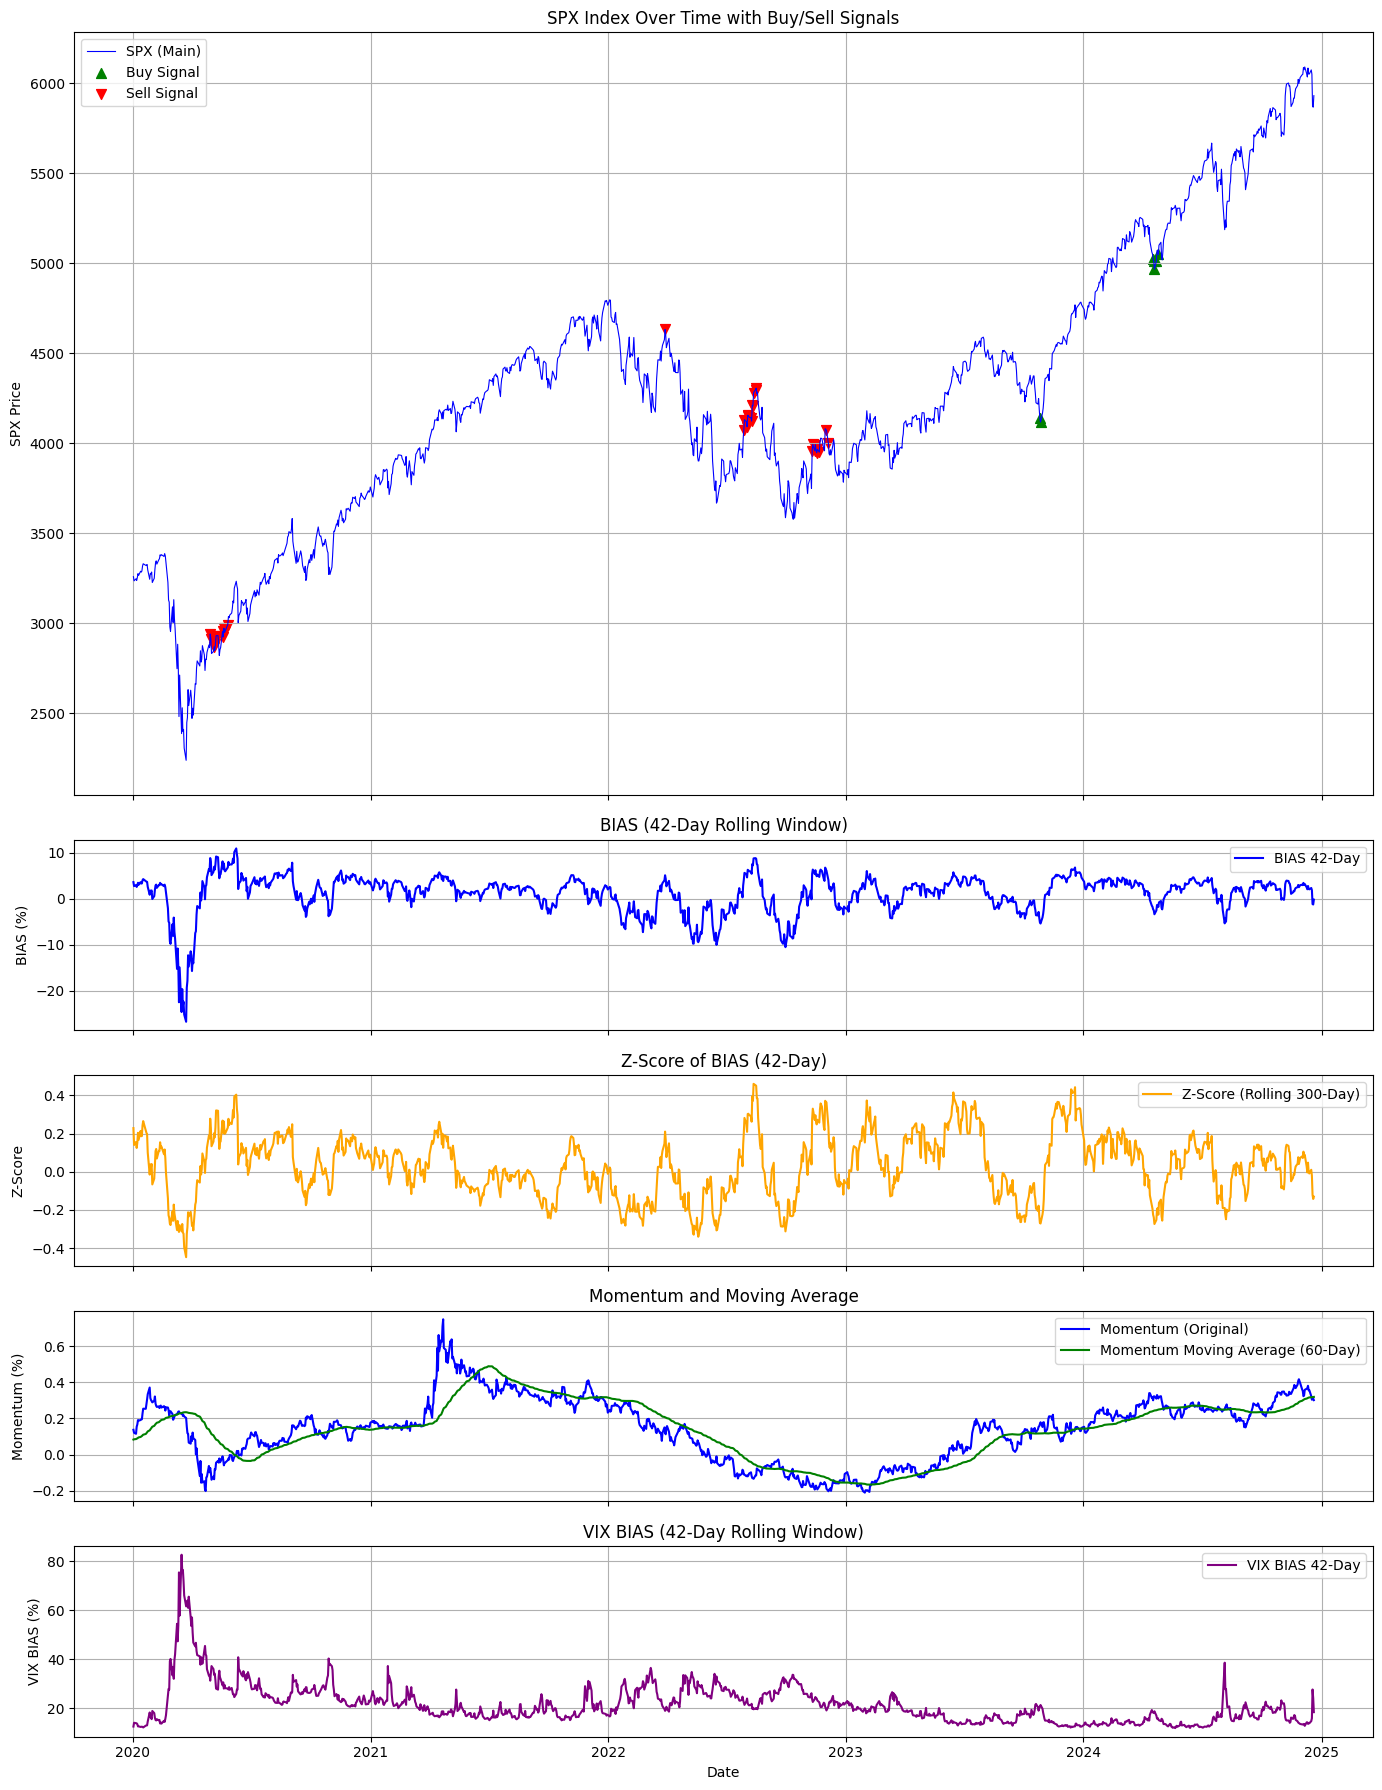

In [5]:
# Define buy and sell conditions
bias_col = f"BIAS_{short_window}"
z_score_col = f"Z_Score_{bias_col}_{z_window}"

# Conditions for Buy and Sell signals
buy_condition = (df_filtered[z_score_col] < -0.2) & (df_filtered["Momentum"] > df_filtered[momentum_ma_col]+0.05)
sell_condition = (df_filtered[z_score_col] > 0.2) & (df_filtered["Momentum"] < df_filtered[momentum_ma_col]-0.05)

# Create subplots with adjusted height ratios
fig, axs = plt.subplots(5, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [4, 1, 1, 1, 1]}, sharex=True)

# Plot SPY as the main plot with buy and sell signals
axs[0].plot(df_filtered.index, df_filtered["SPX"], label="SPX (Main)", color="blue", linewidth=0.8)
axs[0].scatter(df_filtered.index[buy_condition], df_filtered["SPX"][buy_condition], color="green", label="Buy Signal", marker="^", s=50)
axs[0].scatter(df_filtered.index[sell_condition], df_filtered["SPX"][sell_condition], color="red", label="Sell Signal", marker="v", s=50)
axs[0].set_title("SPX Index Over Time with Buy/Sell Signals")
axs[0].set_ylabel("SPX Price")
axs[0].legend()
axs[0].grid(True)

# Plot BIAS
axs[1].plot(df_filtered.index, df_filtered[bias_col], label=f"BIAS {short_window}-Day", color="blue")
axs[1].set_title(f"BIAS ({short_window}-Day Rolling Window)")
axs[1].set_ylabel("BIAS (%)")
axs[1].legend()
axs[1].grid(True)

# Plot Z-Score of BIAS
axs[2].plot(df_filtered.index, df_filtered[z_score_col], label=f"Z-Score (Rolling {z_window}-Day)", color="orange")
axs[2].set_title(f"Z-Score of BIAS ({short_window}-Day)")
axs[2].set_ylabel("Z-Score")
axs[2].legend()
axs[2].grid(True)

# Plot Momentum
axs[3].plot(df_filtered.index, df_filtered["Momentum"], label="Momentum (Original)", color="blue")
axs[3].plot(df_filtered.index, df_filtered[momentum_ma_col], label=f"Momentum Moving Average ({momentum_window}-Day)", color="green")
axs[3].set_title("Momentum and Moving Average")
axs[3].set_ylabel("Momentum (%)")
axs[3].legend()
axs[3].grid(True)

# Plot VIX_BIAS
vix_bias_col = f"VIX_BIAS_{short_window}"
axs[4].plot(df_filtered.index, df_filtered['VIX'], label=f"VIX BIAS {short_window}-Day", color="purple")
axs[4].set_title(f"VIX BIAS ({short_window}-Day Rolling Window)")
axs[4].set_xlabel("Date")
axs[4].set_ylabel("VIX BIAS (%)")
axs[4].legend()
axs[4].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_37195/3746592586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Position"] = 1
/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_37195/3746592586.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 0.25
/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_37195/3746592586.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

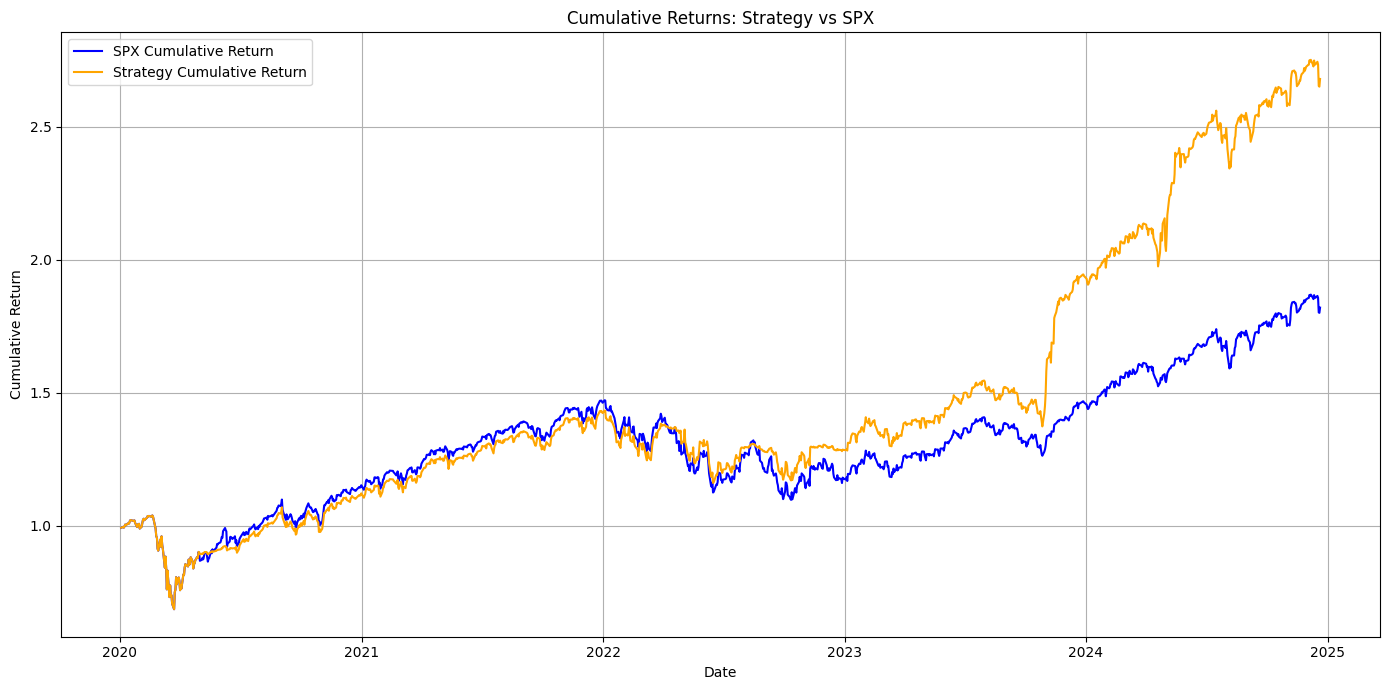

In [6]:
# Initialize the Position column with the default value (1 for 100% SPY)
df_filtered["Position"] = 1

# Get the DataFrame indices for manipulation
df_indices = df_filtered.index

# Iterate through buy signals and set positions to 3 for the next 15 rows
for idx in df_filtered[buy_condition].index:
    start_idx = df_indices.get_loc(idx)  # Get the integer location of the index
    end_idx = min(start_idx + 21, len(df_filtered))  # Ensure index within bounds
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 3

# Iterate through sell signals and set positions to 0.5 for the next 15 rows
for idx in df_filtered[sell_condition].index:
    start_idx = df_indices.get_loc(idx)  # Get the integer location of the index
    end_idx = min(start_idx + 21, len(df_filtered))  # Ensure index within bounds
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 0.25


# change position in next day
df_filtered["Position"] = df_filtered["Position"].shift(1)

# Calculate daily returns for SPY
df_filtered["SPX_Return"] = df_filtered["SPX"].pct_change()

# Calculate strategy returns based on position
df_filtered["Strategy_Return"] = df_filtered["SPX_Return"] * df_filtered["Position"]

# Calculate cumulative returns for SPY and the strategy
df_filtered["SPX_Cumulative"] = (1 + df_filtered["SPX_Return"]).cumprod()
df_filtered["Strategy_Cumulative"] = (1 + df_filtered["Strategy_Return"]).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df_filtered.index, df_filtered["SPX_Cumulative"], label="SPX Cumulative Return", color="blue")
plt.plot(df_filtered.index, df_filtered["Strategy_Cumulative"], label="Strategy Cumulative Return", color="orange")
plt.title("Cumulative Returns: Strategy vs SPX")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Recession Early Sign

In [1]:
from fredapi import Fred

fred = Fred(api_key='ab746526067b62ac85bcf51ef80eae5a')


class US:

    def __init__(self):
        
        ## all the info from categories you can search for
        #stock market index
        self.stocks = {'SP500':'S&P 500', 'DJIA':'Dow Jones'
                       , 'NASDAQCOM':'NASDAQ', 'WILL5000INDFC':'Wilshire 5000'
                       , 'NASDAQ100':'NASDAQ 100'}
        
        #interest rates
        self.rates = {'AMERIBOR':'Overnight Unsecured AMERIBOR'
                     , 'MORTGAGE30US':'30-Year Fixed Rate Mortgage Average'
                     , 'DFEDTARU':'Federal Funds Rate Upper'}
        
        #macro econ data
        self.econ = {'CPIAUCSL':'CPI', 'CORESTICKM159SFRBATL':'CPI less food&energy'
                              ,'PCE':'PCE'
                              ,'EXHOSLUSM495S':'Existing Home Sales'
                              , 'HOSMEDUSM052N':'Median Sales Price of Existing Homes'
                              ,'CSUSHPINSA':'S&P/Case-Shiller U.S. National Home Price Index'
                              ,'PPIACO':'PPI: All Commodities'
                              ,'PCUOMFGOMFG':'PPI: Total Manufacturing Industries'
                              ,'PCUATRNWRATRNWR':'PPI: Transportation and Warehousing Industries'
                              ,'PCUARETTRARETTR':'PPI: Total Retail Trade Industries'
                              ,'UNRATE':'Unemployment Rate'
                              ,'TOTALSA':'Total Vehicle Sales'
                              ,'USHVAC':'Home Vacancy Rate for the United States'
                              ,'CCSA':'Continued Claims (Insured Unemployment)'
                              ,'M2SL':'M2'
                              ,'BOGZ1FL153064476Q': 'Household Held  Equities as a Percentage of Total Assets'
                              }
        
        # us dollar
        self.currency = {'DTWEXBGS':'Nominal Broad U.S. Dollar Index', 'DEXCHUS':'usd/rmb'
                               ,'DEXUSEU':'usd/euro', 'DEXJPUS':'usd/Japanese Yen'
                               ,'DTWEXBGS':'Nominal Broad U.S. Dollar Index'}
        
    def get_data(self, index, ndays = 0):
        # a function to get index data in past n days
        data = pd.DataFrame(data = fred.get_series(index)).reset_index()
        data.columns = ['Date', index]
        return data.iloc[-ndays:,]
    
    def get_pct_change(self, index, ndays = 0, YoY = None):
        # a function to get index percentage change in past n days
        data = pd.DataFrame(data = fred.get_series(index)).reset_index()
        data.columns = ['Date', str(index+' Growth')]
        data.set_index('Date', inplace = True)
        pct = data.pct_change(periods = 1).reset_index()
        # year on year growth 计算同比
        ### only for monthly data 仅限月度数据###
        if YoY:
            pct = data.pct_change(periods = 12).reset_index()
            pct.dropna(inplace = True)
        return pct.iloc[-ndays:,]
    
US_data = US()

In [2]:
pce = US_data.get_pct_change('PCE')
pce.rename(columns={'PCE Growth':'PCE_PCH', 'Date':'DateTime'}, inplace=True)
pce

NameError: name 'pd' is not defined

In [9]:
SPX_prices = df[['SPX']].resample('M').last()  # Resample to monthly and get last price
df_monthly = df[['SPX']].resample('M').last()
df_monthly_returns = df_monthly.pct_change()
df_monthly_returns['SPX_Price'] = SPX_prices['SPX'].values
df_monthly_returns.reset_index(inplace=True)
df_monthly_returns['DateTime'] = df_monthly_returns['DateTime'] + pd.offsets.MonthBegin(0)
df_merged = pd.merge(df_monthly_returns, pce, on="DateTime")
df_merged

/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_37195/2294433806.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  SPX_prices = df[['SPX']].resample('M').last()  # Resample to monthly and get last price
/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_37195/2294433806.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[['SPX']].resample('M').last()


,DateTime,SPX,SPX_Price,PCE_PCH
0,2005-11-01,NaN,1206.42,0.000861
1,2005-12-01,0.035784,1249.59,0.003901
2,2006-01-01,-0.001520,1247.69,0.010077
3,2006-02-01,0.025808,1279.89,0.002690
4,2006-03-01,0.000250,1280.21,0.004057
...,...,...,...,...
224,2024-07-01,0.034670,5460.48,0.006016
225,2024-08-01,0.011321,5522.30,0.001948
226,2024-09-01,0.022835,5648.40,0.006988
227,2024-10-01,0.020197,5762.48,0.003497


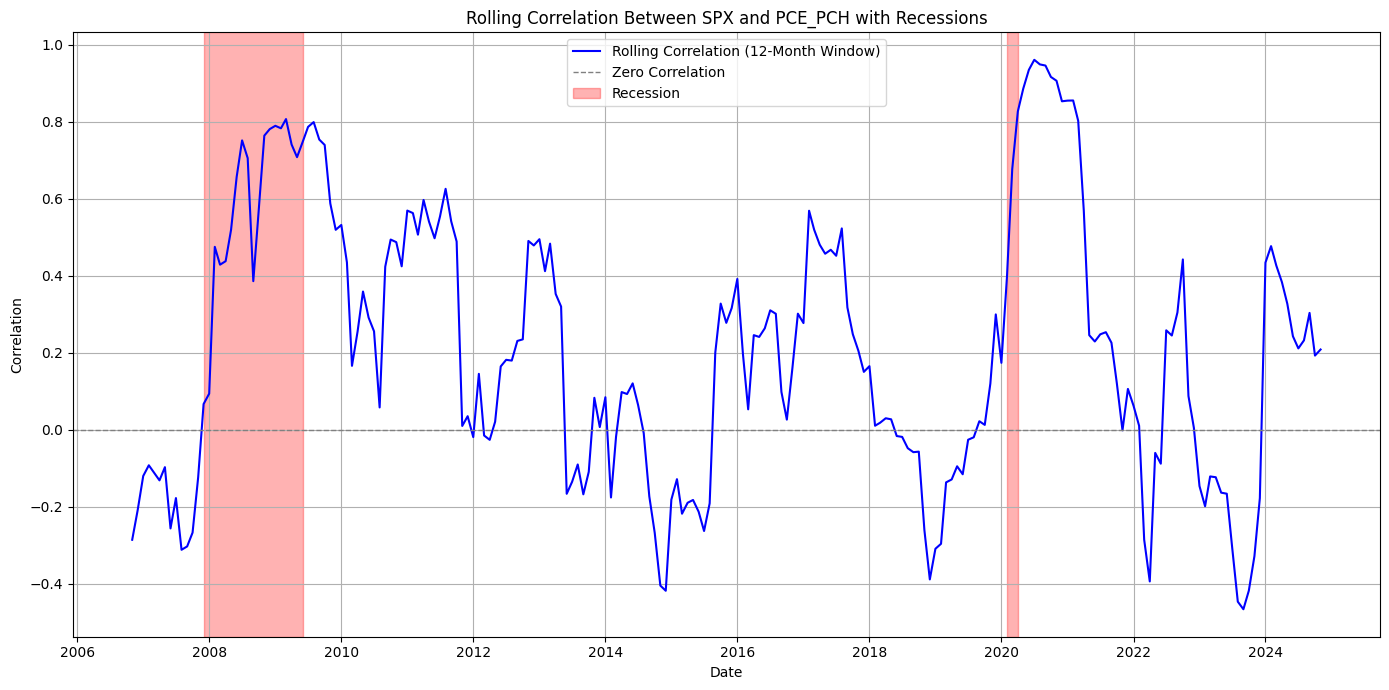

In [10]:
# Define the rolling window size (e.g., 12 months for a 1-year window)
rolling_window = 12

# Calculate rolling correlations between NASDAQCOM and PCE_PCH
df_merged['Rolling_Correlation'] = df_merged['SPX'].rolling(window=rolling_window).corr(df_merged['PCE_PCH'])

# Define recession periods (example: start and end dates for recessions)
recessions = [
    ("2007-12-01", "2009-06-01"),
    ("2020-02-01", "2020-04-01"),
]

# Convert recession periods to datetime for plotting
recession_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in recessions]

# Plot the rolling correlation with recession shading
plt.figure(figsize=(14, 7))
plt.plot(df_merged['DateTime'], df_merged['Rolling_Correlation'], label=f'Rolling Correlation ({rolling_window}-Month Window)', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Correlation')

# Add shaded areas for recessions
for start, end in recession_periods:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")

plt.title('Rolling Correlation Between SPX and PCE_PCH with Recessions')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

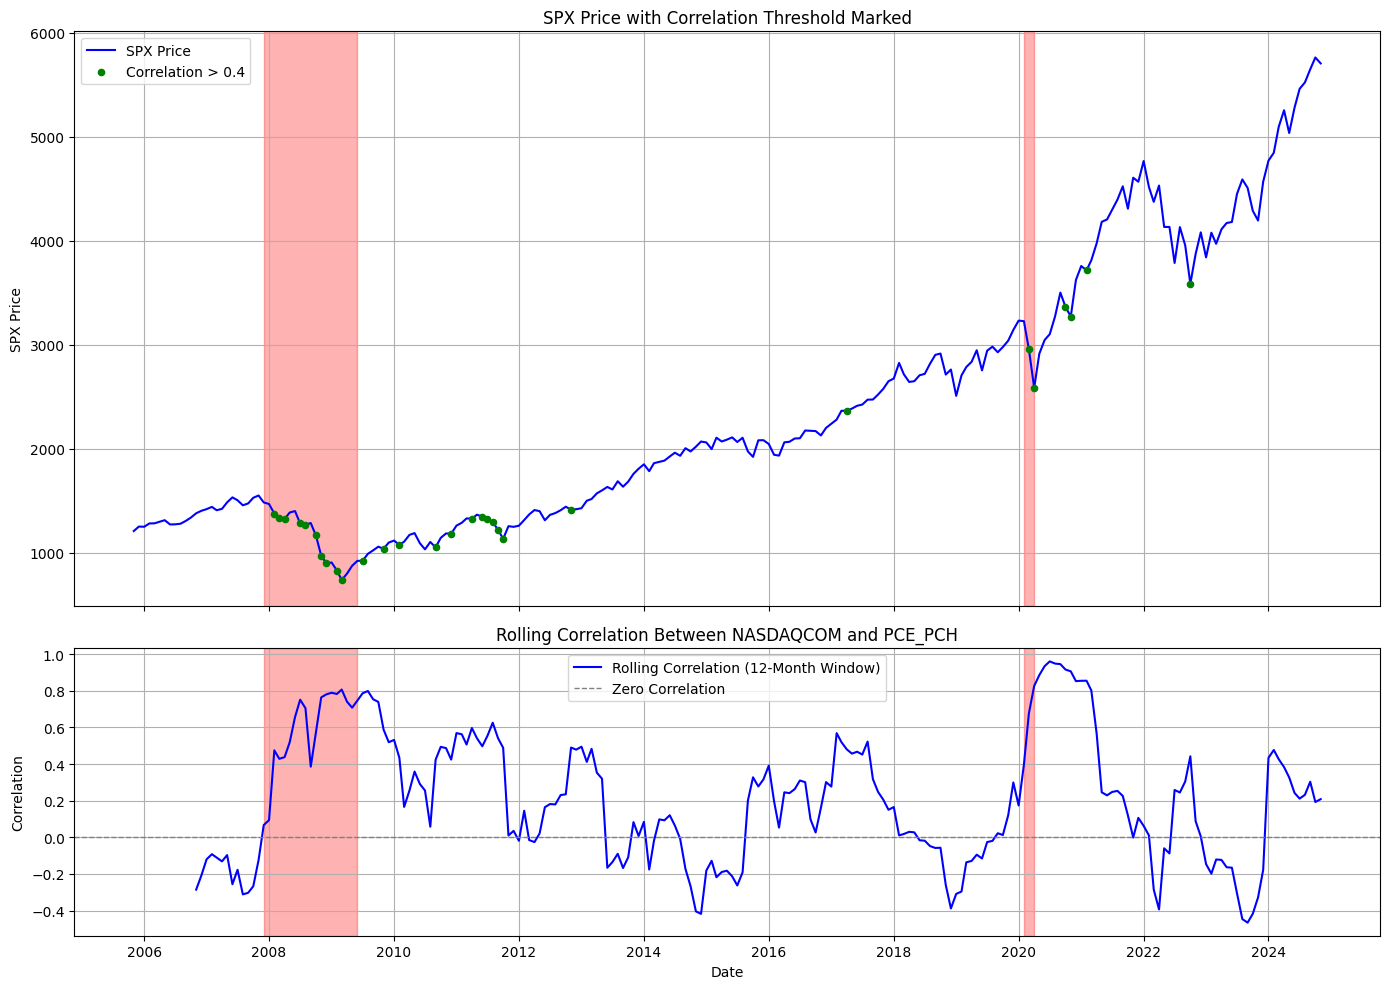

In [11]:
# Create a figure with two subplots: NASDAQ price and correlation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot NASDAQCOM prices on the top subplot
ax1.plot(df_merged['DateTime'], df_merged['SPX_Price'], label='SPX Price', color='blue')
ax1.set_title('SPX Price with Correlation Threshold Marked')
ax1.set_ylabel('SPX Price')
ax1.grid(True)
ax1.legend()

# Highlight periods where Rolling_Correlation > 0.6
threshold = 0.4
highlight = df_merged[(df_merged['Rolling_Correlation'] > threshold) & ((df_merged['SPX_Price'].diff() < 0))]
ax1.scatter(highlight['DateTime'], highlight['SPX_Price'], color='green', label=f'Correlation > {threshold}', zorder=5, s=20)  # Smaller marker size
ax1.legend()

# Plot Rolling Correlation on the bottom subplot
ax2.plot(df_merged['DateTime'], df_merged['Rolling_Correlation'], label=f'Rolling Correlation ({rolling_window}-Month Window)', color='blue')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Correlation')
ax2.set_title('Rolling Correlation Between NASDAQCOM and PCE_PCH')
ax2.set_xlabel('Date')
ax2.set_ylabel('Correlation')
ax2.legend()
ax2.grid(True)

# Add recession shading on both subplots
for start, end in recession_periods:
    ax1.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")
    ax2.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")

plt.tight_layout()
plt.show()


# Margin Debt

In [6]:
M2 = US_data.get_data('M2SL')
Margin_D = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/margin-statistics.xlsx')
Margin_D['Year-Month'] = pd.to_datetime(Margin_D['Year-Month'])
Margin_D['debt'] = Margin_D.iloc[:,1] * 10**6
Margin_D["release_date"] = (Margin_D["Year-Month"] + pd.offsets.MonthBegin(1) + pd.Timedelta(days=27))
M2['M2_amount'] = M2['M2SL'] * 10**9
Margin_D

,Year-Month,Debit Balances in Customers' Securities Margin Accounts,Free Credit Balances in Customers' Cash Accounts,Free Credit Balances in Customers' Securities Margin Accounts,debt,release_date
0,1997-01-01,103337,68856,NaN,103337000000,1997-02-28
1,1997-02-01,103886,67058,NaN,103886000000,1997-03-28
2,1997-03-01,104835,69553,NaN,104835000000,1997-04-28
3,1997-04-01,102842,64825,NaN,102842000000,1997-05-28
4,1997-05-01,111097,66879,NaN,111097000000,1997-06-28
...,...,...,...,...,...,...
330,2024-07-01,810835,154951,150738.0,810835000000,2024-08-28
331,2024-08-01,797162,148702,152107.0,797162000000,2024-09-28
332,2024-09-01,813211,167901,158358.0,813211000000,2024-10-28
333,2024-10-01,815368,173638,164752.0,815368000000,2024-11-28


/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_64854/2515905470.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_m2 = M2[M2["Date"] <= release_date].iloc[-1][1]


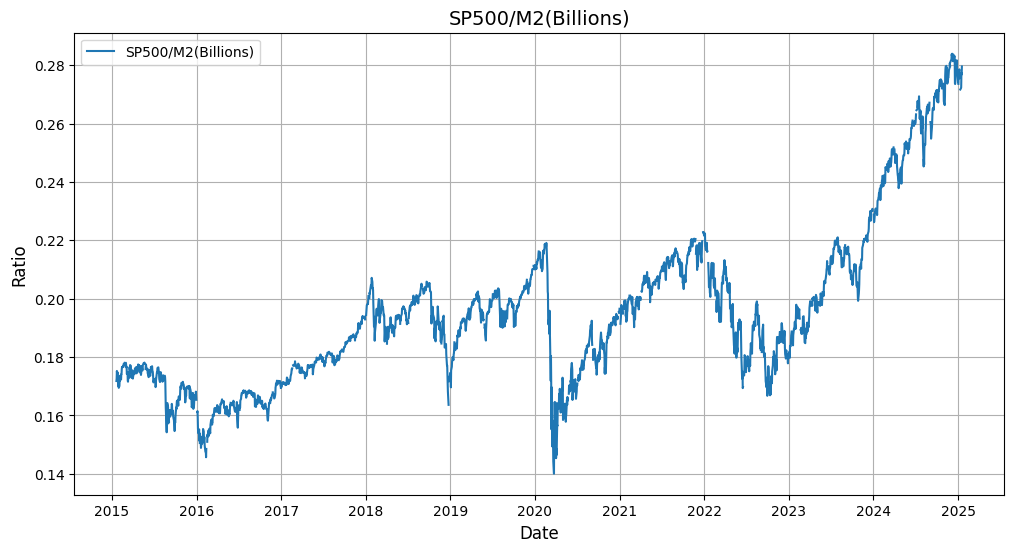

In [7]:
sp500 = US_data.get_data('SP500')

# Match each release_date to the latest M2_amount that doesn't exceed the date
matched_sp_m2 = []
for release_date in sp500["Date"]:
    latest_m2 = M2[M2["Date"] <= release_date].iloc[-1][1]
    matched_sp_m2.append(latest_m2)

# Add matched M2 to Margin_D DataFrame
sp500["Matched_M2"] = matched_sp_m2

# Calculate the ratio of debt to M2
sp500["SP500/M2(Billions)"] = sp500["SP500"] / (sp500["Matched_M2"])

# Plot the Debtover time
plt.figure(figsize=(12, 6))
plt.plot(sp500["Date"], sp500["SP500/M2(Billions)"], label="SP500/M2(Billions)", linewidth=1.5)
plt.title("SP500/M2(Billions)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

/var/folders/hk/ysvf16597_13lb0mk93zgbsc0000gn/T/ipykernel_64854/2801691750.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_m2 = M2[M2["Date"] <= release_date].iloc[-1][1]


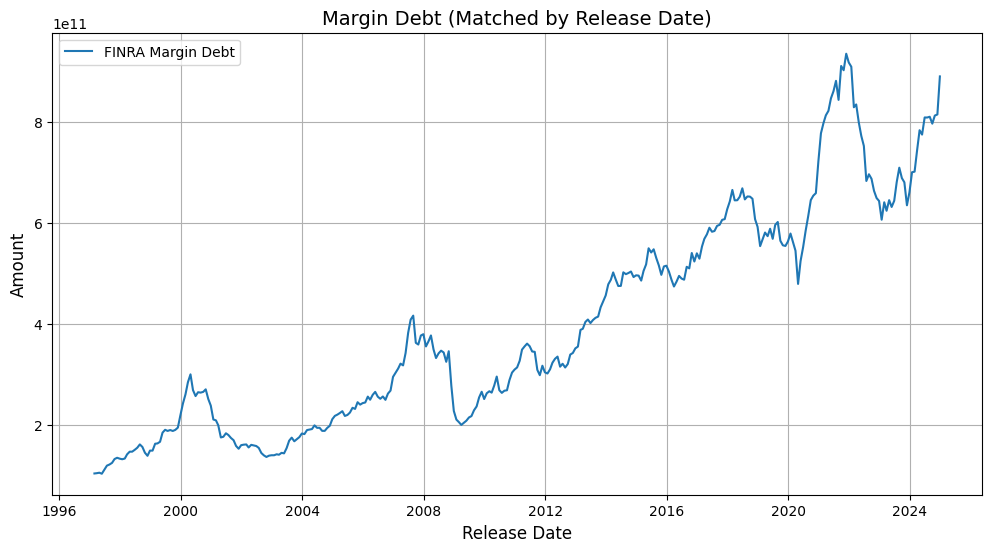

In [8]:
# Match each release_date to the latest M2_amount that doesn't exceed the date
matched_m2 = []
for release_date in Margin_D["release_date"]:
    latest_m2 = M2[M2["Date"] <= release_date].iloc[-1][1]
    matched_m2.append(latest_m2)

# Add matched M2 to Margin_D DataFrame
Margin_D["Matched_M2"] = matched_m2

# Calculate the ratio of debt to M2
Margin_D["Debt/M2"] = Margin_D["debt"] / (Margin_D["Matched_M2"]*10**9)

# Plot the Debtover time
plt.figure(figsize=(12, 6))
plt.plot(Margin_D["release_date"], Margin_D["debt"], label="FINRA Margin Debt", linewidth=1.5)
plt.title("Margin Debt (Matched by Release Date)", fontsize=14)
plt.xlabel("Release Date", fontsize=12)
plt.ylabel("Amount", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

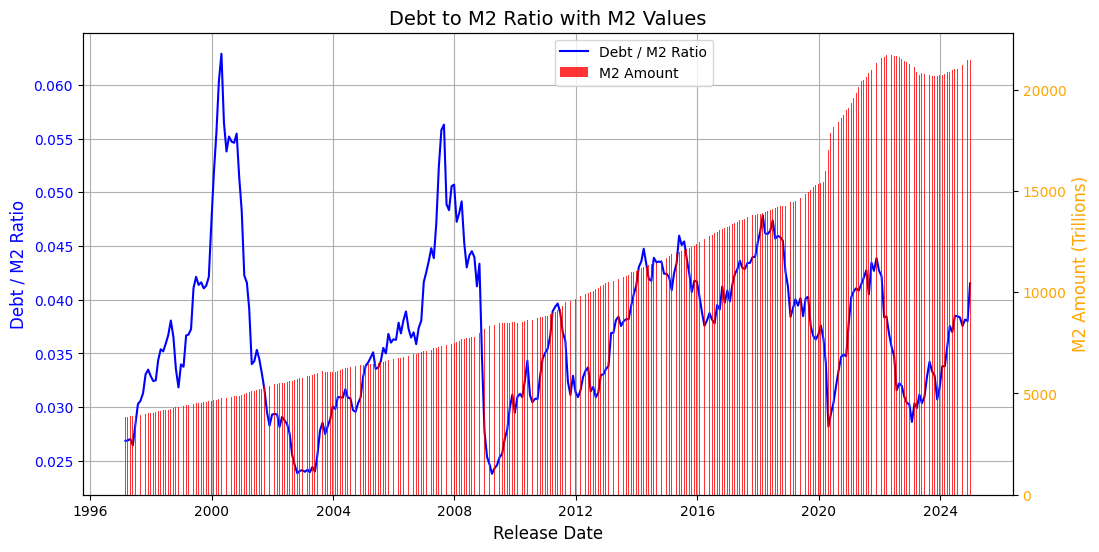

In [9]:
# Plot with dual axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Debt/M2 ratio as a line plot on the primary y-axis
ax1.plot(Margin_D["release_date"], Margin_D["Debt/M2"], label="Debt / M2 Ratio", linewidth=1.5, color='blue')
ax1.set_xlabel("Release Date", fontsize=12)
ax1.set_ylabel("Debt / M2 Ratio", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Debt to M2 Ratio with M2 Values", fontsize=14)
ax1.grid(True)

# Create a secondary y-axis for M2 values
ax2 = ax1.twinx()
ax2.bar(Margin_D["release_date"], Margin_D["Matched_M2"], label="M2 Amount", alpha=0.8, color='red', width=10)
ax2.set_ylabel("M2 Amount (Trillions)", fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.5, 1), bbox_transform=ax1.transAxes)

plt.show()

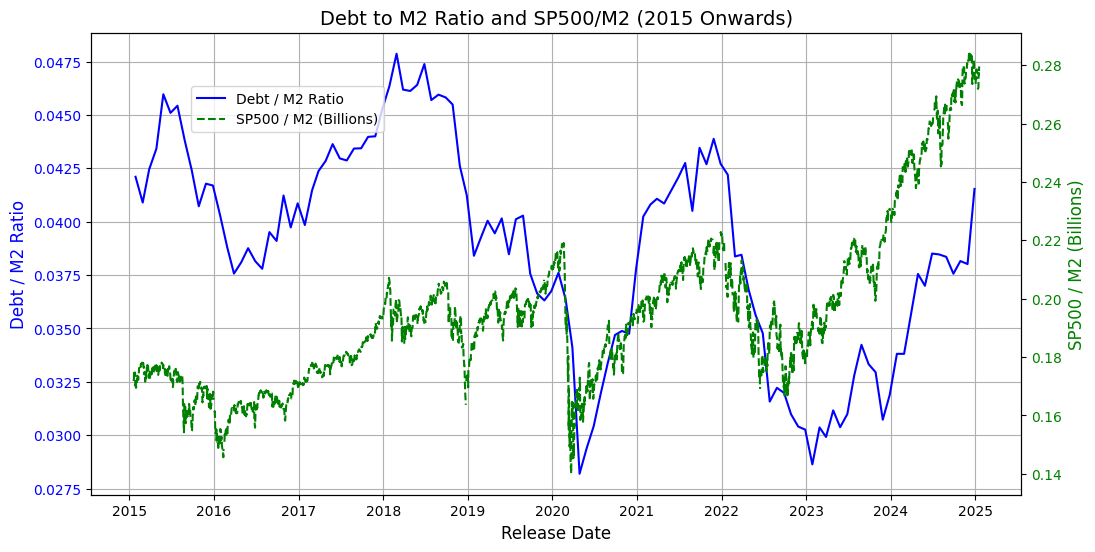

In [10]:
# Filter both datasets to start from 2015
Margin_D = Margin_D[Margin_D["release_date"] >= pd.to_datetime("2015-01-01")]
sp500 = sp500[sp500["Date"] >= pd.to_datetime("2015-01-01")]

# Plot with dual axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Debt/M2 ratio on the primary y-axis
ax1.plot(
    Margin_D["release_date"], 
    Margin_D["Debt/M2"], 
    label="Debt / M2 Ratio", 
    linewidth=1.5, 
    color='blue'
)
ax1.set_xlabel("Release Date", fontsize=12)
ax1.set_ylabel("Debt / M2 Ratio", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Debt to M2 Ratio and SP500/M2 (2015 Onwards)", fontsize=14)
ax1.grid(True)

# Create a secondary y-axis for SP500/M2
ax2 = ax1.twinx()
ax2.plot(
    sp500["Date"], 
    sp500["SP500/M2(Billions)"], 
    label="SP500 / M2 (Billions)", 
    linewidth=1.5, 
    color='green', 
    linestyle='--'
)
ax2.set_ylabel("SP500 / M2 (Billions)", fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.show()

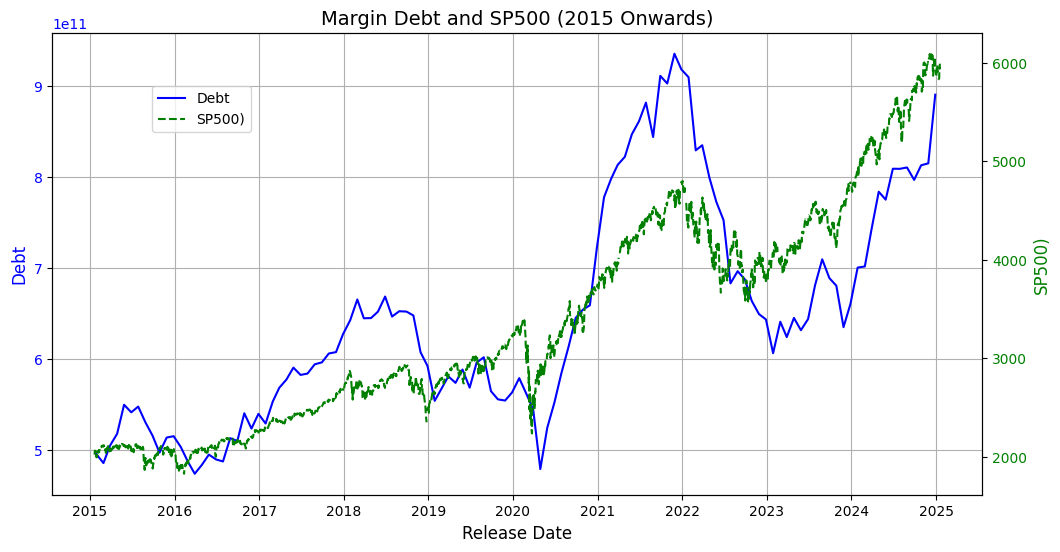

In [11]:
# Filter both datasets to start from 2015
Margin_D = Margin_D[Margin_D["release_date"] >= pd.to_datetime("2015-01-01")]
sp500 = sp500[sp500["Date"] >= pd.to_datetime("2015-01-01")]

# Plot with dual axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Debt/M2 ratio on the primary y-axis
ax1.plot(
    Margin_D["release_date"], 
    Margin_D["debt"], 
    label="Debt", 
    linewidth=1.5, 
    color='blue'
)
ax1.set_xlabel("Release Date", fontsize=12)
ax1.set_ylabel("Debt", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Margin Debt and SP500 (2015 Onwards)", fontsize=14)
ax1.grid(True)

# Create a secondary y-axis for SP500/M2
ax2 = ax1.twinx()
ax2.plot(
    sp500["Date"], 
    sp500["SP500"], 
    label="SP500)", 
    linewidth=1.5, 
    color='green', 
    linestyle='--'
)
ax2.set_ylabel("SP500)", fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.show()

# 极端估值

In [17]:
pe = pd.read_excel('/Users/charlesxiong/Desktop/IBKR_algo/ie_data.xls', sheet_name='PE')
pe["Date"] = pe["Date"].astype(str)
pe["Date"] = pe["Date"].apply(lambda x: re.sub(r'\.1(?!\d)', '.10', x))
pe["Date"]

0       1871.01
1       1871.02
2       1871.03
3       1871.04
4       1871.05
         ...   
1844    2024.09
1845    2024.10
1846    2024.11
1847    2024.12
1848    2025.01
Name: Date, Length: 1849, dtype: object

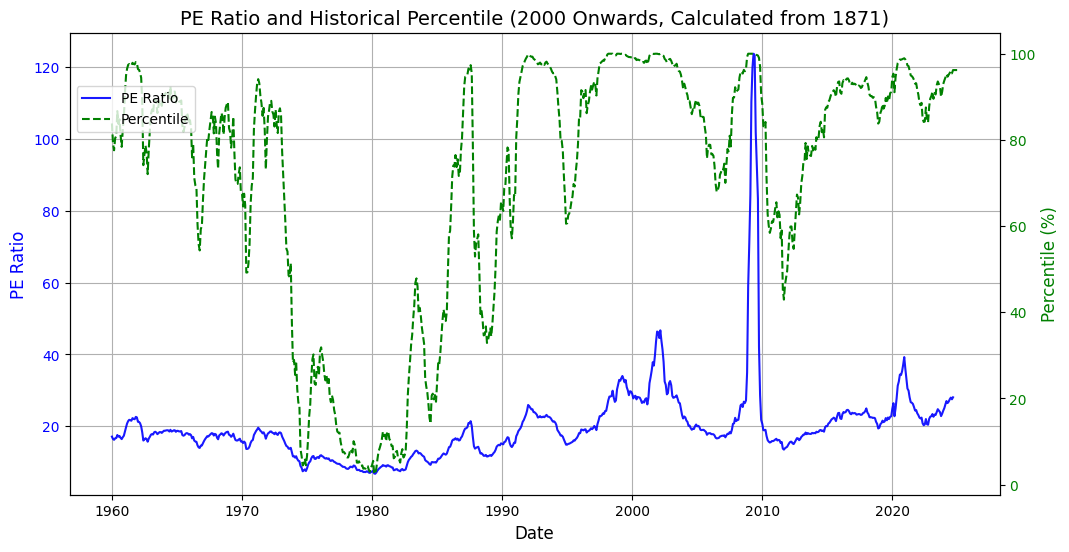

In [18]:
# Convert 'Date' to datetime, handling the floating point year-month format
pe["Date"] = pd.to_datetime(pe["Date"].astype(str), format="%Y.%m", errors="coerce")

# Filter the data to include only dates from 2000 onwards for plotting
pe_filtered = pe[pe["Date"] >= pd.to_datetime("1960-01-01")].reset_index(drop=True)

# Initialize an empty list to store percentiles
percentiles = []

# Loop through each row from 2000 onwards to calculate the percentile based on all data from 1871 to the current row
for i in range(len(pe_filtered)):
    subset = pe[pe["Date"] <= pe_filtered.loc[i, "Date"]].dropna(subset=["PE Ratio"])  # Include all data up to the current date
    current_percentile = subset["PE Ratio"].rank(pct=True).iloc[-1] * 100  # Calculate percentile for the last value
    percentiles.append(current_percentile)

# Add the calculated percentiles to the filtered DataFrame
pe_filtered["Percentile"] = percentiles

# Plot the PE Ratio and Percentile starting from 2000
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot PE Ratio on the primary y-axis
ax1.plot(pe_filtered["Date"], pe_filtered["PE Ratio"], label="PE Ratio", color='blue', linewidth=1.5, alpha=0.9)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("PE Ratio", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("PE Ratio and Historical Percentile (2000 Onwards, Calculated from 1871)", fontsize=14)
ax1.grid(True)

# Create a secondary y-axis for the Percentile
ax2 = ax1.twinx()
ax2.plot(pe_filtered["Date"], pe_filtered["Percentile"], label="Percentile", color='green', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Percentile (%)", fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0, 0.9), bbox_transform=ax1.transAxes)

plt.show()


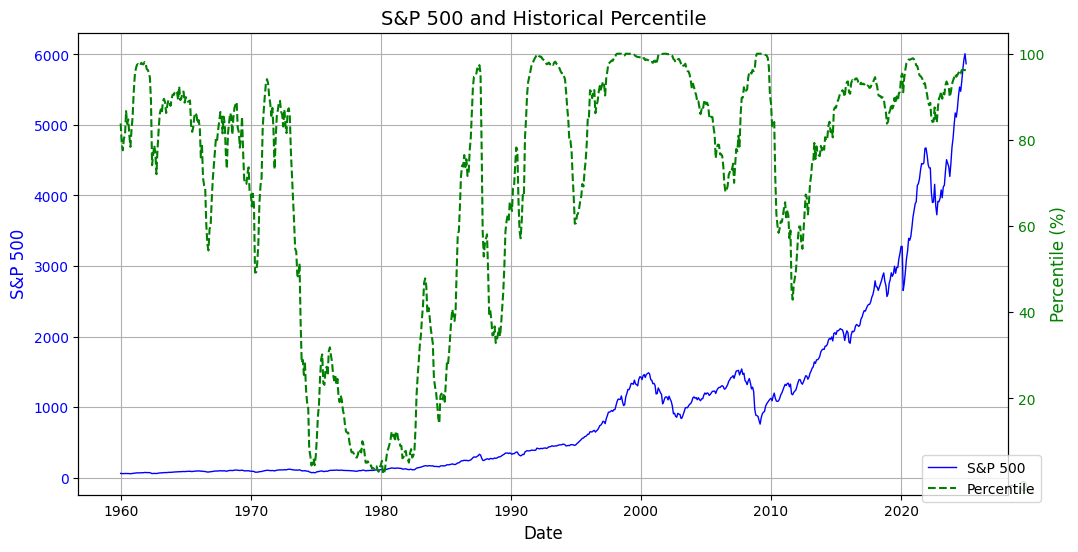

In [19]:
# Plot S&P 500 and Percentile
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot SP500 on the primary y-axis
# Line plot for SP500 with small markers
ax1.plot(
    pe_filtered["Date"], 
    pe_filtered["SP500"], 
    label="S&P 500", 
    color='blue', 
    linewidth=1,  # Thin line
    alpha=1  # Slight transparency for the line
)
# ax1.scatter(
#     pe_filtered["Date"], 
#     pe_filtered["SP500"], 
#     color='blue', 
#     s=0,  # Small markers
#     alpha=0.1, 
#     label=None  # Avoid duplicate legend entries
# )
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("S&P 500", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("S&P 500 and Historical Percentile", fontsize=14)
ax1.grid(True)

# Create a secondary y-axis for the Percentile
ax2 = ax1.twinx()
ax2.plot(pe_filtered["Date"], pe_filtered["Percentile"], label="Percentile", color='green', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Percentile (%)", fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.9, 0.1), bbox_transform=ax1.transAxes)

plt.show()

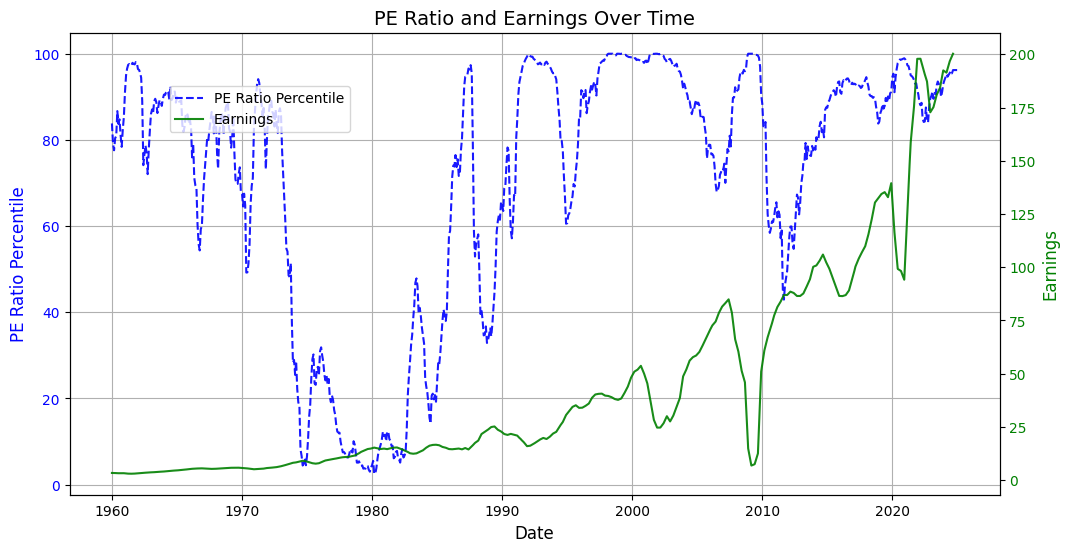

In [20]:
# Plot PE Ratio and Earnings as line plots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot PE Ratio on the primary y-axis
ax1.plot(
    pe_filtered["Date"], 
    pe_filtered["Percentile"], 
    label="PE Ratio Percentile", 
    color='blue', 
    linewidth=1.5, 
    alpha=0.9,
    linestyle='--'
)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("PE Ratio Percentile", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for Earnings
ax2 = ax1.twinx()
ax2.plot(
    pe_filtered["Date"], 
    pe_filtered["Earings"], 
    label="Earnings", 
    color='green', 
    linewidth=1.5, 
    alpha=0.9
)
ax2.set_ylabel("Earnings", fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add titles and legends
ax1.set_title("PE Ratio and Earnings Over Time", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.show()